### Project: Analyze fluctuations in HTTP request latency data to determine reliability

Appendix:
- Prepare data:
	- Create sample data from script (data has interval time is 30 second)
- Build SLO about latency for service
- Analyze data
	- Load data (.csv) to dataframe
	- Standardize data
	    - Set index for dataframe is timestamp
	- Explore data
        - Analyze fluctuations on the dataset
		- Apply pct_change (relative change) for good fluctuations observer 
		- Conclusion of the problem
    - SLI Calculator
        - Simulator rate() on rolling windows
        - Calculate percentile: [50th, 90th, 95th, 99th] or latency in time vector
	
- Apply model

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [65]:
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2, 5, 10, "+Inf"]

In [66]:
# Load dataset from CSV file
root = pd.read_csv(
    '../statics/csv/request_data_with_anomaly_pod_instance_2.csv', index_col=0)

In [67]:
# Convert to datetime pandas and set datetime columns is index for dataframe
root.index = pd.to_datetime(root.index)
root.head()

,path,method,service_name,controller_pod,0.005,0.01,0.025,0.05,0.1,0.25,0.5,1,2,5,10,+Inf
timestamp,,,,,,,,,,,,,,,,
2024-04-02 22:06:00,/home,GET,process_log,pod-1,0,0,0,1,2,6,10,21,21,21,21,21
2024-04-02 22:06:00,/home,GET,process_log,pod-2,0,0,0,0,1,3,9,14,14,14,14,14
2024-04-02 22:06:00,/users,GET,process_log,pod-1,0,0,0,1,2,2,8,15,15,15,15,15
2024-04-02 22:06:00,/users,GET,process_log,pod-2,0,0,0,0,0,4,9,18,18,18,18,18
2024-04-02 22:06:30,/home,GET,process_log,pod-1,0,0,0,1,5,16,27,43,43,43,43,43


### Build SLO about latency for service
#### Define SLOs

- Service type: HTTP
- SLO type: Latency
- SLO:
    - 90% requests < 200ms
    - 95% request < 600ms
    - 99% requests < 1000ms

In [68]:
grouped = ['service_name', 'controller_pod', 'path', 'method']
cols_for_calculate = [str(col) for col in BUCKETS]
percentiles = {
    "median": 0.50,
    "75th_percentile": 0.75,
    "95th_percentile": 0.95,
    "99th_percentile": 0.99,
}

In [69]:
# Get total request for service
total_request = root.groupby(grouped).last()['+Inf'].sum()
print("Total request: ", total_request)
# Calculate Error budget
print("Objective: ")
for k, v in percentiles.items():
      print(f"{k} value: ", int((1 - v) *total_request))

Total request:  730
Objective: 
median value:  365
75th_percentile value:  182
95th_percentile value:  36
99th_percentile value:  7


### Analyze fluctuations on the dataset

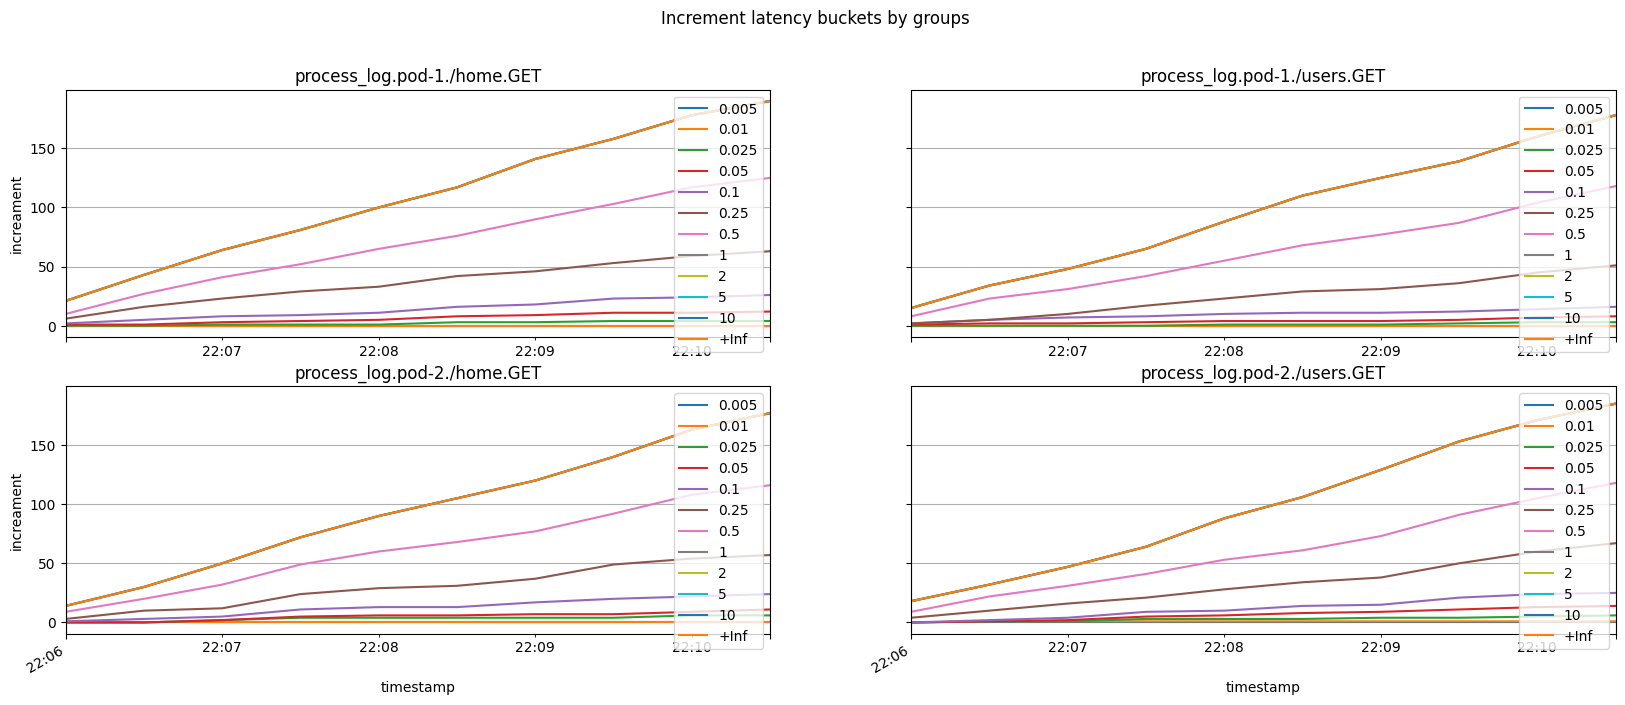

In [70]:
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
chart_data = root.groupby(grouped)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 8), sharey=True)
fig.suptitle('Increment latency buckets by groups')
# Configure x-axis date ticks
locator = AutoDateLocator(minticks=5, maxticks=10)
formatter = AutoDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
for (name, df), ax in zip(chart_data, axes.flat):
    name = ".".join(list(name))
    df.plot(kind="line", ax=ax, title=name, grid=True)
    ax.set(xlabel='timestamp', ylabel='increament')

plt.gcf().autofmt_xdate()
plt.show()

Kết quả cho thấy tăng trưởng trên mối bucket của các group rất đồng đều. Nhưng ở group **process_log.pod-1./users.GET** có 2 đoạn thời gian chỉ tăng trưởng đối với bucket +Inf, còn các bucket khác đều không có tăng trưởng gì. Có vấn đề gì về data trong khoảng thời gian này? Thực hiện zoom vào đoạn thời gian đó để điều tra nguyên nhân

-> Khoảng thời gian có requests chứa duration_time > 500ms: ['2024-01-02 11:00:00', '2024-01-02 12:30:00']

In [71]:
abnormal_group = "path == '/users' and controller_pod == 'pod-1'"

### Apply pct_change (relative change) for good fluctuations observer 

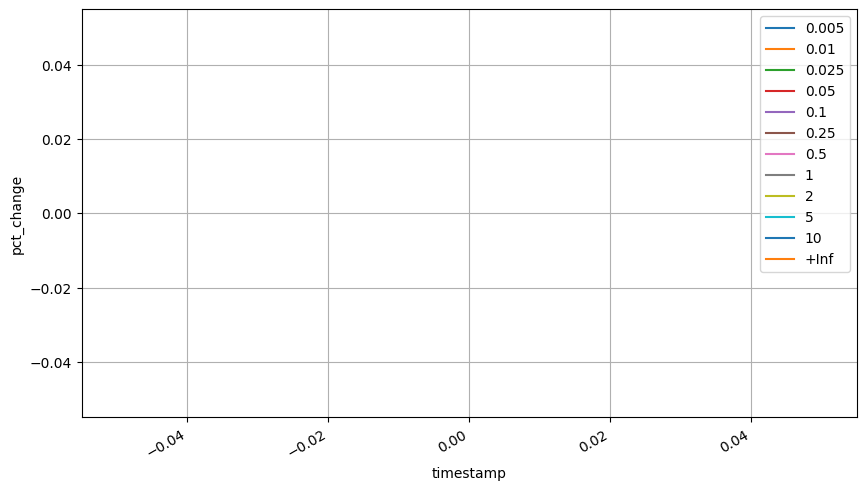

,timestamp,0.005,0.01,0.025,0.05,0.1,0.25,0.5,1,2,5,10,+Inf


In [72]:

sample_data_abnormal = root.query(abnormal_group)[cols_for_calculate]

# Apply pct_change (relative change) for good fluctuations observer

sample_data_abnormal.pct_change().loc['2024-01-02 12:00:00':'2024-01-02 12:20:00'].plot(
    grid=True, figsize=(10, 6), ylabel="pct_change")
plt.gcf().autofmt_xdate()
plt.show()

# Highligh color columns in dataframe


def highlight_cols(s, color):
    return 'background-color: %s' % color


sample_data_abnormal.pct_change().loc['2024-01-02 12:20:00':'2024-01-02 12:30:00'].reset_index().style.\
    map(highlight_cols, color="yellow", subset=pd.IndexSlice[4:15, cols_for_calculate[:7]]).\
    map(highlight_cols, color="green",
        subset=pd.IndexSlice[:, cols_for_calculate[7:]]).\
    map(highlight_cols, color="cyan", subset=pd.IndexSlice[:, cols_for_calculate[7:8]])

### Conclusion of the problem

Lúc này đã thấy rõ hơn được khoảng thời gian và những biến động về duration_time trong khoảng thời gian đó. Có thể thấy rằng trong khoảng thời gian từ 12:22:00 -> 12:27:30 thì các bucket [từ 0.005 -> 0.5] (phạm vi màu vàng) đều không có biến động do không có request nào được fill vào các nhóm này tuy nhiên nhưng vẫn có sự biến động trên bucket **1** (màu cyan) mặc dù không đáng kể.

Thêm nữa, chú ý tới phạm vi màu green (bucket [2 -> +Inf]), các bucket này có giá trị trong các đoạn thời gian đều không giống nhau, nguyên nhân bởi vì các giá trị duration_time của dataset trong khoảng thời gian này đều fill vào các bucket trên. *Ví dụ: Một bản log request có duration_time=1.123s sẽ được fill vào trong các bucket [2, 5, 10, +Inf] bởi vì giá trị duration_time=1.123 đều nhỏ hơn các giá trị [2, 5, 10, +Inf]. 

Thêm thông tin về bucketing hay Histogram có thể xem tại: https://en.wikipedia.org/wiki/Histogram*

Từ 2 dữ kiện trên có thể kết luận về vấn đề xảy ra đối với tập dữ liệu: **Có nhiều request có duration_time > 0.5s trong khoảng thời gian từ 2024-01-02 12:22:00 -> 2024-01-02 12:27:30**

## SLI Calculator

In [73]:
# Simulator rate() in 30s
root.query(abnormal_group).head()

,path,method,service_name,controller_pod,0.005,0.01,0.025,0.05,0.1,0.25,0.5,1,2,5,10,+Inf
timestamp,,,,,,,,,,,,,,,,
2024-04-02 22:06:00,/users,GET,process_log,pod-1,0,0,0,1,2,2,8,15,15,15,15,15
2024-04-02 22:06:30,/users,GET,process_log,pod-1,0,0,0,2,5,5,23,34,34,34,34,34
2024-04-02 22:07:00,/users,GET,process_log,pod-1,0,0,0,2,7,10,31,48,48,48,48,48
2024-04-02 22:07:30,/users,GET,process_log,pod-1,0,0,0,3,8,17,42,65,65,65,65,65
2024-04-02 22:08:00,/users,GET,process_log,pod-1,0,0,1,4,10,23,55,88,88,88,88,88


In [74]:
group_dataset = root.groupby(grouped).last().reset_index()[grouped]
group_dataset

,service_name,controller_pod,path,method
0,process_log,pod-1,/home,GET
1,process_log,pod-1,/users,GET
2,process_log,pod-2,/home,GET
3,process_log,pod-2,/users,GET


In [75]:
# Implement rate calculation for each group
list_df_rated = []


def rate(group: pd.Series):
    sample = root[(root["service_name"] == group['service_name'])
                  & (root["controller_pod"] == group['controller_pod'])
                  & (root["path"] == group['path'])
                  & (root["method"] == group['method'])]
    for col in cols_for_calculate:
        sample[col] = sample[col].diff() / sample.index.diff().total_seconds()
    sample.fillna(0, inplace=True)
    list_df_rated.append(sample)


for idx, group in group_dataset.iterrows():
    rate(group)

df_rated = pd.concat(list_df_rated)
df_rated.head()

,path,method,service_name,controller_pod,0.005,0.01,0.025,0.05,0.1,0.25,0.5,1,2,5,10,+Inf
timestamp,,,,,,,,,,,,,,,,
2024-04-02 22:06:00,/home,GET,process_log,pod-1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-04-02 22:06:30,/home,GET,process_log,pod-1,0.0,0.0,0.000000,0.000000,0.100000,0.333333,0.566667,0.733333,0.733333,0.733333,0.733333,0.733333
2024-04-02 22:07:00,/home,GET,process_log,pod-1,0.0,0.0,0.033333,0.066667,0.100000,0.233333,0.466667,0.700000,0.700000,0.700000,0.700000,0.700000
2024-04-02 22:07:30,/home,GET,process_log,pod-1,0.0,0.0,0.000000,0.033333,0.033333,0.200000,0.366667,0.566667,0.566667,0.566667,0.566667,0.566667
2024-04-02 22:08:00,/home,GET,process_log,pod-1,0.0,0.0,0.000000,0.033333,0.066667,0.133333,0.433333,0.633333,0.633333,0.633333,0.633333,0.633333


In [76]:
# Simulator histogram_quantile
# Calculate sum(rate)
sum_rate_bucket = {}
for bucket in cols_for_calculate:
    sum_rate_bucket[float(bucket)] = df_rated[bucket].sum()
sum_rate_bucket_df = pd.DataFrame(
    data={"bucket": sum_rate_bucket.keys(), "rate": sum_rate_bucket.values()})


In [77]:
sum_rate_bucket_df.drop_duplicates(subset="rate")

,bucket,rate
0,0.005,0.000000
1,0.010,0.033333
2,0.025,0.633333
3,0.050,1.433333
4,0.100,2.866667
5,0.250,7.433333
6,0.500,14.700000
7,1.000,22.066667


In [78]:
# Count value fill in bucket
value_count_buckets = []
for bucket in BUCKETS:
    record = {
        "bucket": bucket,
        "val": root.groupby(grouped)[str(bucket)].last().sum()
    }
    value_count_buckets.append(record)
pd.DataFrame().from_records(value_count_buckets)


,bucket,val
0,0.005,0
1,0.01,1
2,0.025,19
3,0.05,45
4,0.1,91
5,0.25,238
6,0.5,477
7,1,730
8,2,730
9,5,730


In [79]:
# Function to calculate quantile with linear interpolation
import numpy as np


def linear_interpolation_quantile(df, q):
    cumulative_counts = np.cumsum(df['rate'])
    total_count = cumulative_counts.iloc[-1]

    # Find the bin containing the quantile
    bin_index = np.argmax(cumulative_counts >= q * total_count)

    # Linear interpolation between adjacent bins
    lower_bin_edge = df['bucket'].iloc[bin_index - 1]
    upper_bin_edge = df['bucket'].iloc[bin_index]
    interpolate_ratio = (
        q * total_count - cumulative_counts.iloc[bin_index - 1]) / df['rate'].iloc[bin_index]

    quantile_value = lower_bin_edge + interpolate_ratio * \
        (upper_bin_edge - lower_bin_edge)
    return quantile_value

In [80]:
sli = []
for k, v in percentiles.items():
    record = {
        "percentile": k,
        "value(seconds)": linear_interpolation_quantile(
        sum_rate_bucket_df.drop_duplicates(subset="rate"), v),
    }
    sli.append(record)
pd.DataFrame().from_records(sli)
        
    

,percentile,value(seconds)
0,median,0.457200
1,75th_percentile,0.721488
2,95th_percentile,0.944298
3,99th_percentile,0.988860
